# Flower Recognition

In [21]:
from os import listdir
from random import shuffle

import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from keras.models import Sequential
from keras import regularizers
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split

### Load & format the data

In [22]:
flower_filenames = listdir('flowers')

flower_categories = {
    'daisy':     0,
    'dandelion': 1,
    'rose':      2,
    'sunflower': 3,
    'tulip':     4
}

# Normal arrays in order to let us dynamically append
x, y = [], []

# Shuffle the filenames as that'll randomize the data and labels while still keeping their order
shuffle(flower_filenames)

for file_count, filename in enumerate(flower_filenames):
    if file_count % 500 == 0: print(f'Loading {file_count}/{len(flower_filenames)}')
    
    image = Image.open('flowers/' + filename)
    
    # Resize the images to 64x64 as they'll still contain plenty of information for our use case
    image = image.resize((64, 64))
    
    # Grab the ground truth label from the filename and convert it into the correct category
    flower_category = flower_categories[filename.split(' ')[0]]
    
    x.append(np.array(image))
    y.append(flower_category)
    

# Convert to numpy array, as we're done appending
x, y = np.array(x), np.array(y)

print(
    f'x shape: {np.shape(x)}\n'
    f'y shape: {np.shape(y)}'
)

Loading 0/4317
Loading 500/4317
Loading 1000/4317
Loading 1500/4317
Loading 2000/4317
Loading 2500/4317
Loading 3000/4317
Loading 3500/4317
Loading 4000/4317
x shape: (4317, 64, 64, 3)
y shape: (4317,)


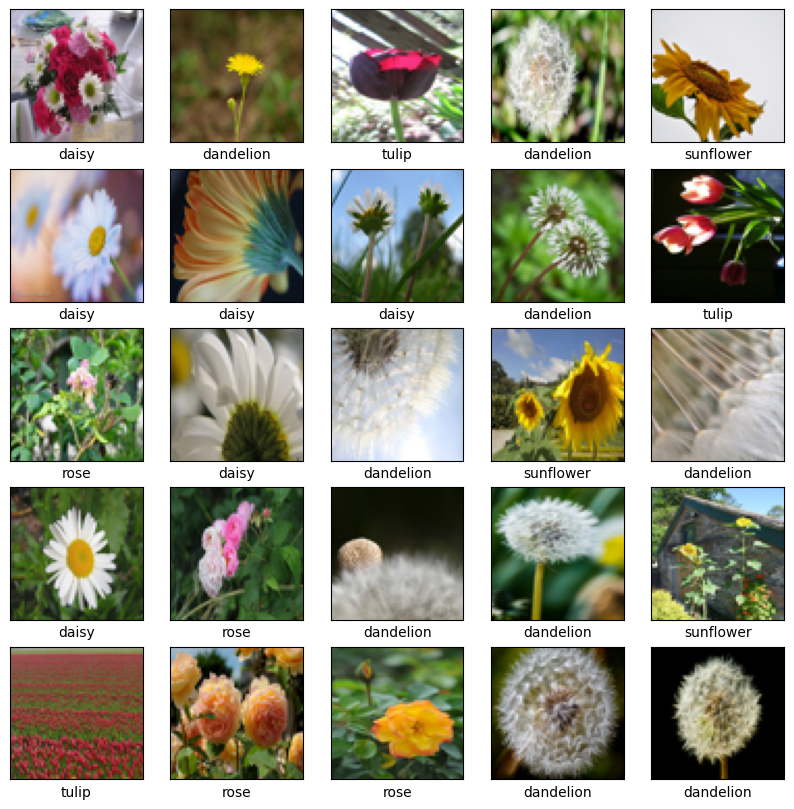

In [23]:
# Easier/cleaner than doing a reverse lookup using flower_names_scheme
flower_names = [
    'daisy',
    'dandelion',
    'rose',
    'sunflower',
    'tulip'
]

plt.figure(figsize=(10,10))

for i in range(25):
    # the subplots are added sequentially, even though the dimentions are specified explicitly
    plt.subplot(5, 5, i + 1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(x[i])
    plt.xlabel(flower_names[y[i]])

plt.show()

### Preprocessing

In [24]:
# Divide by max value to normalize the data
x = x / 255
print(f'x range: {x.min()} - {x.max()}')

x range: 0.0 - 1.0


In [25]:
# This will technically shuffle the data once more. But hey, can't hurt right?
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

print(
    f'x_train shape: {np.shape(x_train)}\n'
    f'y_train shape: {np.shape(y_train)}\n'
    f'x_test shape: {np.shape(x_test)}\n'
    f'y_test shape: {np.shape(y_test)}'
)

x_train shape: (3453, 64, 64, 3)
y_train shape: (3453,)
x_test shape: (864, 64, 64, 3)
y_test shape: (864,)


### Create & train model

In [26]:
model = Sequential([
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01), input_shape=(64, 64, 3)),
    Conv2D(filters=32, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Conv2D(filters=64, kernel_size=(3, 3), padding='same', activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    MaxPooling2D(pool_size=2, strides=2, padding='same'),
    
    Flatten(),
    Dense(units=128, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
    Dense(units=5, activation='softmax'),
])

# Using sparse_categorical_crossentropy instead of categorical_crossentropy as sparse allows us to use integer labels
# instead of needing some other encoding scheme
model.compile(optimizer='Adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

In [17]:
# Using a patience and start_from_epoch of 10 as the model is still all over the place before that 
early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, start_from_epoch=10)
history = model.fit(x_train, y_train, epochs=100, validation_split=0.2, callbacks=[early_stopping])

Epoch 1/100
87/87 [==============================] - 85s 937ms/step - loss: 2.3696 - accuracy: 0.3903 - val_loss: 1.6064 - val_accuracy: 0.4834
Epoch 2/100
87/87 [==============================] - 85s 974ms/step - loss: 1.5373 - accuracy: 0.4761 - val_loss: 1.4161 - val_accuracy: 0.5384
Epoch 3/100
87/87 [==============================] - 77s 889ms/step - loss: 1.3937 - accuracy: 0.5127 - val_loss: 1.3337 - val_accuracy: 0.5818
Epoch 4/100
87/87 [==============================] - 77s 890ms/step - loss: 1.3580 - accuracy: 0.5167 - val_loss: 1.2545 - val_accuracy: 0.5832
Epoch 5/100
87/87 [==============================] - 69s 795ms/step - loss: 1.2943 - accuracy: 0.5453 - val_loss: 1.2076 - val_accuracy: 0.5904
Epoch 6/100
87/87 [==============================] - 69s 791ms/step - loss: 1.2893 - accuracy: 0.5416 - val_loss: 1.2660 - val_accuracy: 0.5557
Epoch 7/100
87/87 [==============================] - 70s 803ms/step - loss: 1.2665 - accuracy: 0.5652 - val_loss: 1.2278 - val_accuracy:

### Evaluate performance

In [18]:
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

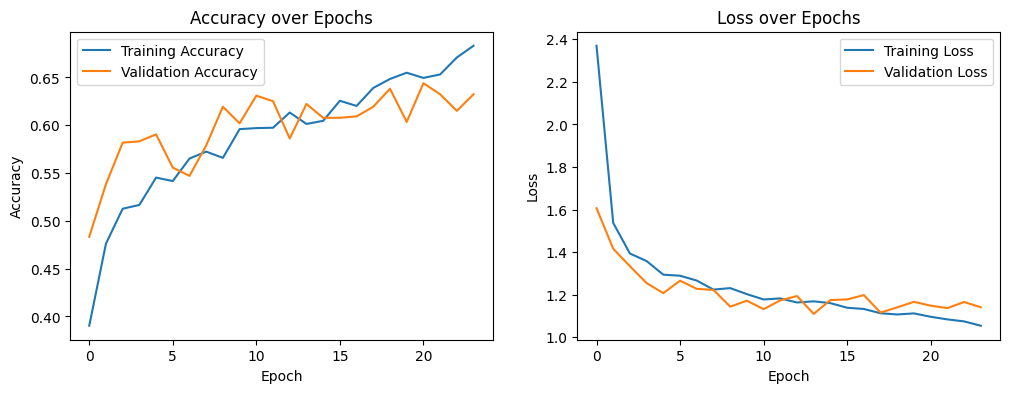

Accuracy: 59.0%
Loss: 1.16


In [19]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Accuracy over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Loss over Epochs')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.show()

print(
    f'Accuracy: {round(test_accuracy, 2) * 100}%\n'
    f'Loss: {round(test_loss, 2)}'    
)

### Hyperparameter usage motivation

- #### Motivera din modellarkitektur och val av relevanta hyperparametrar.<br>
    
    The model architecture follows that of a basic CNN with conv and pooling layers, as can be seen in the code.
    The reason i chose two conv layres with 32 filters at first is quite straight forward. The innitial layers of a CNN only serve to extra extremely basic features such as edges, lines, corners.. etc.
    Thus the filter count should be rather small. Next up, the network performs max pooling with two strides in order to downscale the images by half. This is done to reduce the overall compute power needed, as the extracted features are still meaningfully (from an information theory standpoint) there, even though we humans may not be able to spot them.

    Next we run the data through two more conv layers, this time with double the filter count in order to really extract those key defining features in our flower dataset. One max pooling layer later and we're ready to flatten and feed the data into the dense, fully connected part of the network. Here I've chosen 128 neurons for the input (more on why later), and 5 for the output (given our label count)

    And that's really all there is to it on the architecture front. Now for the hyperparameters, which i'll be elaborating and explaning on one by one.

  - Conv2D filters
    - Trial and error (a recurring theme, as you'll see). I ran the model a few times with different filter counts in the various layers and, after doing much more research into how CNNs work, decided on 32 filters for the innitial layers and 64 for the latter. The first layers don't really need all that many filters, as they're generalizing to extremely genetic shapes such as edges, vertical lines, horizontal lines.. etc.
    The latter layers are the ones that specialize, hence the doubling of filter count.
      
  - Conv2D kernel (filter) size
    - Experimented with a few sizes and settled on the relatively standard 3x3 as it performed the best and in my opinnion overlaps enough with the surrounding pixels.
      
  - Conv2D/MaxPooling2D padding
    - Used "same" so as to not shrink the already tiny images even further. "same" will also remove the bias of having the filter only pass over the boarder pixels once as opposed to several times with the inner ones.
      
  - Conv2D/Dense activation
    - Relu on all except for the output. Relu is one of the best and most well known activation functions given its speed vs performance tradeoff, which made me decide to leave it be on all except for the output layer. The reason the output layer uses softmax is because softmax helps in generating probabilities as output for classification.
  
  - Conv2D/Dense regularization
    - After having tweaked the preceding hyperparameters to my liking i noticed the network was still overfitting to quite a gross degree. So naturally, i opted for regularization!<br>
    Started off by testing L1, L2 and L1 & L2, eventually settling on what made the most sense, L2. This helped with the issue at hand quite a bit, with the resultant model not nearly overfitting to the same extent.
  
  - MaxPooling2D pool size/stride
    - The images are already tiny, no need to downscale further than 2x, hence a stride of 2. Also left the pool size to 2x2 as that's what everyone else uses. It's a simple pooling layer, not the standard model lagrangian. No need for overcomplication.

  - Dense units
    - As before, manual trial and error. 128 nodes is what worked best for me, without absolutely grilling my shitbox school computer to high hell. That poor CPU...



- #### Vilka aktiveringsfunktioner har du använt? Varför?
  - Already stated above

- #### Vilken loss funktion har du använt? Varför?
  - I ended up using sparse_categorical_crossentropy as that was the most appropriate for a classifier. I could technically have used the standard categorical_crossentropy and just one hot encoded my labels, but that would've added unnecessary complexity. If the developers bothered to add a "sparse" version, why not use it?

- #### Har du använt någon databehandling? Varför?
  - Yes, but not a lot. I firstly needed a simple way to load the data and labels. After careful consideration, i decided that the best course of action would be to simply rename the image files to their corresponding flower names, than drag them into one single folder. This was to avoid unnecessarily complex programmatic logic, allowing me to use one simple loop for loading the data and labels.<br><br>
  I than needed to scale the images before i could efficiently feed them through the network, as they where much too big in their native form. I eventually settled scaling them down to 64x64, as that still provided an adequate amount of information (as judged by my biological photon sensor matrices) for classification.

- #### Har du använt någon regulariseringsteknik? Motivera.
  - Already stated above

- #### Hur har modellen utvärderats?
  - By looking at the validation accuracy and loss

- #### Är prestandan bra? Varför/ varför inte?
  - For a basic bitch network i slapped togeather in one afternoon? yea!<br>
  In general? No, not really.<br>Though it's worth mentioning that there are 5 labels, meaning the model's roughly 60% accuracy is actually far in advance of the 20% you'd expect from a totally random prediction. So it's clearly learnt something!

- #### Vad hade du kunnat göra för att förbättra den ytterligare?
  - There are a myriad of possible techniques which i didn't explore. Everything from simply continuing to mess around with the architecture, to performing a comprehensive gridsearch of the parameter space in order to obtain the best model. Even a few more conv and dense layers may have given the model a slight advantage. But that would've also made the train time an order of magnitude longer (trust me, i tried). All of this is to say that in this field of computer science, you can always tweak things. One must call it quits at some point!